# Figure 9cd - LE and H Summer Event

## 1 - Import Necessary Modules

In [29]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import matplotlib.pyplot as plt 
import numpy as np 
import proplot as plot
import proplot
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from wrf import xy_to_ll 

# warnings
import warnings
warnings.filterwarnings('ignore')

## 2 - Functions to Open Datasets and Select Relevant Variables

In [1]:
def create_total_hs_variable(data):
    """
    Creates total rain ACHFX, ACLHF given the cumulative convective and cumulative normal WRF data
    """
    time = data['time']
    Hs = data
    Hs_total = []
    
    
    
    for i in range(len(time.values)):
        if i != 0:
            hs_wait = Hs.isel(time=i).values - Hs.isel(time=i-1).values
            Hs_total.append(hs_wait)
        else:
            Hs_total.append(Hs.isel(time=i).values)
    
    copy_data = data.copy()
    copy_data['HSTOT'] = (['time', 'south_north', 'west_east'], np.array(Hs_total))
    return copy_data['HSTOT'] / 3600 # to W/m2

In [3]:
#Upward latent and sensible heat flux at surface
def open_wrf_with_variable(member_list, start, end, run_type, var):
    """ ÖZET:
    Buradaki olay şu: tüm ensemble memberlarının yağış verilerini salem ile açıyoruz, daha sonra istenilen zaman aralığına kısıyoruz bu veriyi,
    daha sonra bu modifiye edilmiş ensemble verilerini bir listede biriktirip concat ediyoruz ens boyutu üzerinde, daha sonra bu veri'nin ensemble ortalamasını
    alıyoruz, daha sonra ensemble ortalamasını kullanıcıya saatlik olarak mı döneceğiz yoksa zaman aralığı toplamı mı olarak döneceğiz buna karar veriyoruz.
    
        PARAMETERS:
    member_list: ensemble member adlarının listesi (veriyi açmak için),
    start, end: start ve end olarak datetime object yaratıp verilmeli,
    run_type: urban veya nourban stringleri geçirilmeli (hangi veriyi açacağız?),
    daily_sum_or_average: günlük toplam verisini mi çekeceğiz?
                            True ise evet, False ise saatlik veri çeker.
    
        RETURNS:
    Tüm ensemble verilerini yağış için concat eder "ens" boyutu üzerinde ve ens ortalamasını döner. (saatsel ya da günsel olarak)
    
    """
    ## ----------------------------------------------------- ## ADIM 1
    
    # start ve end vakitlerini numpy dt64'e çevirelim
    dt64_start = np.datetime64(start)
    dt64_end = np.datetime64(end)
    
    ## ----------------------------------------------------- ## ADIM 2
    # içinde saatlik wrf verilerini biriktireceğimiz liste
    time_sliced_ensemble = []
    for ens in member_list:
        # hangi ensemble üyesinde olduğumuzu belirtelim
        print("{} ensemble'ı çözülüyor..".format(ens))
        
        ALL = salem.open_wrf_dataset(r'\summer_datasets\ankara_{}_{}\wrfout_d03_2016-08-26_00_00_00'.format(ens, run_type))
        
        ## ----------------------------------------------------- ## ŞİMDİLİK ÖNEMSİZ ADIM BAŞLANGIÇ
        # dt64 start ve endi kullanarak np.where komutu ile indexlerini bulalım zamanların ve isel komutu ile bu indexleri kullanalım.
        # aşağıdaki kodu xr open dataset ile açarsak kullanabiliriz.
        #time_sliced_data = ALL['PRCP'].isel(time = slice(np.where(tt['time'] == dt64_start)[0][0], np.where(tt['XTIME'] == dt64_end)[0][0] + 1))
        ## ----------------------------------------------------- ## ŞİMDİLİK ÖNEMSİZ ADIM BİTİŞ
        
        # salem ile açılan verinin tamamını alalım çünkü dprog/dt yapacağız.
        time_sliced_data = ALL[var]
        
        # zaman aralıklı verileri bir listede toplayalım
        time_sliced_ensemble.append(time_sliced_data)
        
        # veriyi kapatalım
        ALL.close()
        
    ## ----------------------------------------------------- ## ADIM 3
    
    # saatlik verilerimizi concat edelim ens boyutu üzerinde
    ensemble_runs = xr.concat(time_sliced_ensemble, dim='ens')
    ensemble_runs['ens'] = member_list
    
    ensemble_mean = ensemble_runs.mean(dim='ens') 
    
    ## ----------------------------------------------------- ## ADIM 4
    
    # saatlik veri ise:
    return create_total_hs_variable(ensemble_mean).sel(time = slice(dt64_start, dt64_end))
    #return ensemble_mean
    ## ----------------------------------------------------- ## SON
        

## 3 - Open Datasets

In [4]:
# SENSIBLE HEATING
# URBAN VERİLERİNİ AÇALIM yağıştan önceki 4 saat için
member_list = ['lin', 'thompson', 'wsm6']
start = datetime(2016, 8, 28, 8)
end = datetime(2016, 8, 28, 11)
run_type = 'urban'

urban_ens_mean_hourly = open_wrf_with_variable(member_list, start, end, run_type, var = 'ACHFX')

print('done with urban....')

## ------------------------------------------------------------------------------------------------- ##
# NOURBAN VERİLERİNİ AÇALIM yağıştan önceki 4 saat için
start = datetime(2016, 8, 28, 8)
end = datetime(2016, 8, 28, 11)
run_type = 'nourban'

nourban_ens_mean_hourly = open_wrf_with_variable(member_list, start, end, run_type, var = 'ACHFX')

print('done with nourban....')

sensible_urban_minus_nourban_4hourly_mean = urban_ens_mean_hourly.mean(dim='time') - nourban_ens_mean_hourly.mean(dim='time')

lin ensemble'ı çözülüyor..
thompson ensemble'ı çözülüyor..
wsm6 ensemble'ı çözülüyor..
done with urban....
lin ensemble'ı çözülüyor..
thompson ensemble'ı çözülüyor..
wsm6 ensemble'ı çözülüyor..
done with nourban....


In [5]:
# LATENT HEATING
# URBAN VERİLERİNİ AÇALIM yağıştan önceki 4 saat için
member_list = ['lin', 'thompson', 'wsm6']
start = datetime(2016, 8, 28, 8)
end = datetime(2016, 8, 28, 11)
run_type = 'urban'

urban_ens_mean_hourly = open_wrf_with_variable(member_list, start, end, run_type, var = 'ACLHF')

print('done with urban....')

## ------------------------------------------------------------------------------------------------- ##
# NOURBAN VERİLERİNİ AÇALIM yağıştan önceki 4 saat için
start = datetime(2016, 8, 28, 8)
end = datetime(2016, 8, 28, 11)
run_type = 'nourban'

nourban_ens_mean_hourly = open_wrf_with_variable(member_list, start, end, run_type, var = 'ACLHF')

print('done with nourban....')

latent_urban_minus_nourban_4hourly_mean = urban_ens_mean_hourly.mean(dim='time') - nourban_ens_mean_hourly.mean(dim='time')

lin ensemble'ı çözülüyor..
thompson ensemble'ı çözülüyor..
wsm6 ensemble'ı çözülüyor..
done with urban....
lin ensemble'ı çözülüyor..
thompson ensemble'ı çözülüyor..
wsm6 ensemble'ı çözülüyor..
done with nourban....


In [6]:
# ek plot bilgileri;
#open example data for getting the borders of city
d_urban = Dataset(r'\summer_datasets\ankara_thompson_urban\wrfout_d03_2016-08-26_00_00_00')

d_sol_alt3 = xy_to_ll(d_urban, 0, 0).values
d_sol_ust3 = xy_to_ll(d_urban, 0, 200).values
d_sag_alt3 = xy_to_ll(d_urban, 200, 0).values
d_sag_ust3 = xy_to_ll(d_urban, 200, 200).values

lon_wrf = urban_ens_mean_hourly['lon']
lat_wrf = urban_ens_mean_hourly['lat']

cart_proj = cartopy.crs.LambertConformal( 32.834, 39.873 )

## 4 - Corner Coordinates

In [7]:
#Define urban and rural box coordinates - 
urban_sol_alt_coordinates = [32.63, 39.85]
urban_sol_ust_coordinates = [32.63, 40.01]
urban_sag_alt_coordinates = [32.89, 39.85]
urban_sag_ust_coordinates = [32.89, 40.01]

## 5 - Create Plots

In [8]:
# COLORMAPS
#get lat lon
cmap_diff = plot.Colormap(
    'Blues_r', 'Reds' ,
    ratios=(100/200, 100/200), name='SciVisColor', )

C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


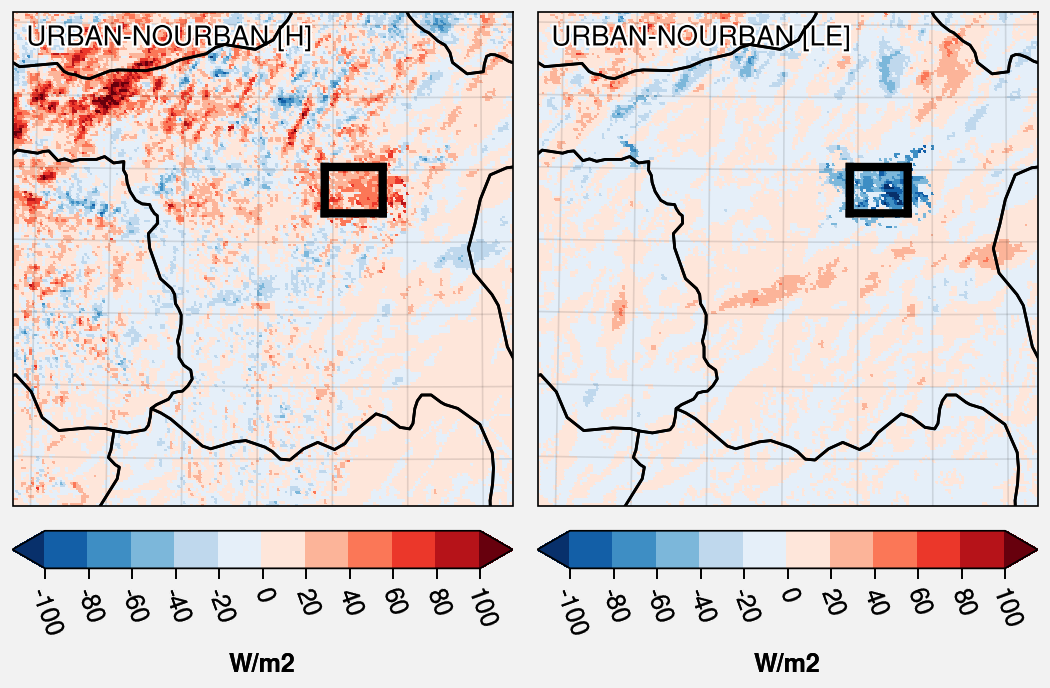

In [10]:
#Starting the plotting
cart_proj = cartopy.crs.LambertConformal( 32.834, 39.873 )
fig, axs = plot.subplots(ncols=2, nrows=1, proj=cart_proj)

#format the plot
axs.format(
    lonlim=(d_sol_alt3[1], d_sag_alt3[1]-0.10),
    latlim=(d_sol_alt3[0], d_sol_ust3[0]-0.10),
    coast = True, labels=False, innerborders=True,
    reso = 'xx-hi', coastlinewidth = 2, innerborderslinewidth = 1,
    land = True, landcolor = '#f0e7d8', landzorder = 0.005,
    borderszorder = 3, innerborderszorder = 3, 
    abc=False, abcstyle='(a)', abcloc='ur')

axs.plot([urban_sol_alt_coordinates[0], urban_sol_ust_coordinates[0]], 
         [urban_sol_alt_coordinates[1], urban_sol_ust_coordinates[1]], 
         transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)
axs.plot([urban_sol_ust_coordinates[0], urban_sag_ust_coordinates[0]], 
         [urban_sol_ust_coordinates[1], urban_sag_ust_coordinates[1]], 
         transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)
axs.plot([urban_sag_ust_coordinates[0], urban_sag_alt_coordinates[0]], 
         [urban_sag_ust_coordinates[1], urban_sag_alt_coordinates[1]], 
         transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)
axs.plot([urban_sol_alt_coordinates[0], urban_sag_alt_coordinates[0]], 
         [urban_sol_alt_coordinates[1], urban_sag_alt_coordinates[1]], 
         transform=cartopy.crs.PlateCarree(), color='black', linewidth=3.0)

## -----------------------------------------URBAN-NOURBAN SENSIBLE HEAT-------------------------------------------------------- ##

# URBAN-NOURBAN ensemble mean için plot
run_plot_sens = axs[0].pcolormesh(lon_wrf, lat_wrf,
                                  sensible_urban_minus_nourban_4hourly_mean,
                                  levels = np.arange(-100, 101, 20),
                                  cmap=cmap_diff, extend='both', 
                                  transform=cartopy.crs.PlateCarree(), zorder = 0.01)

axs[0].format(ultitle = 'URBAN-NOURBAN [H]', fontsize = 10)
cbar = fig.colorbar(run_plot_sens,  label='W/m2',
                    labelweight='bold',
                    ticks = np.arange(-100, 101, 20),
                    loc = 'b', col=1, ) #Adding colorbar with label

cbar.ax.set_xticklabels(labels = np.arange(-100, 101, 20),
                        rotation=290)

## -----------------------------------------URBAN-NOURBAN LATENT HEAT-------------------------------------------------------- ##

# URBAN-NOURBAN ensemble mean için plot
run_plot_latent = axs[1].pcolormesh(lon_wrf, lat_wrf,
                                    latent_urban_minus_nourban_4hourly_mean,
                                    levels = np.arange(-100, 101, 20),
                                    cmap=cmap_diff, extend='both', 
                                    transform=cartopy.crs.PlateCarree(), zorder = 0.01)

axs[1].format(ultitle = 'URBAN-NOURBAN [LE]', fontsize = 10)
cbar = fig.colorbar(run_plot_latent, label='W/m2', 
                    labelweight='bold',
                    ticks = np.arange(-100, 101, 20),
                    loc = 'b', col=2, ) #Adding colorbar with label

cbar.ax.set_xticklabels(labels = np.arange(-100, 101, 20),
                        rotation=290)

#save figure
plt.savefig(r'pictures/figure9cd.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=500)